Step 0. preparation

Step 1. select and plot data

Step 2. calculate b-value


# Step 0.1 Download data from NCEDC

1. go to website: https://www.ncedc.org/ncedc/catalog-search.html
2. choose "Double-difference catalog" in a "readable format"
3. setup parameters for data download (in this example, I choose data in the Bay area with latitude 37 to 38.5, longitude -123 to -121, magnitude 0-9, time 2019/01/01 to 2022/10/12). Note that increase the line limit to obtain all requested events
4. save the data to the directory you prefer (here we use dbsearch.Bay.test.txt)




# Step 0.2 install packages used for analysis

In [1]:
#!conda install -c conda-forge obspy
#!conda install -c conda-forge cartopy

# Step 1.1 import packages and setup parameters for later use

In [2]:
import warnings
warnings.filterwarnings('ignore') # ignore warnings
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import *
%matplotlib inline 
# plot inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') # output figure in png format
import matplotlib.pyplot as plt
from obspy.core.utcdatetime import UTCDateTime #convert time to UTC time
mpl.rcParams['figure.dpi']= 500 # setup the figure resolution


# add the google drive directory into path
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/traffic_light_project/'
path = 'C:/Users/yair_/Documents/Traffic Light Project/'

# Step 1.2 load fault data and earthquake data

In [3]:
qfault=np.loadtxt(path+'qfaults.txt')
# fault data from USGS website

In [4]:
year = []
lat = []
lon = []
dep = []
mag = []
evid = []
time_utc = []
time_year = []
fid = open(path+'hayward84pres.txt')
# read in the header
line = fid.readline()
print(line)
line = fid.readline()
print(line)

#read in event lines
num = 0
for line in fid:
    num = num + 1
    if num%1000 == 0:
        print(num)
    info = line.split()
    if len(info) <2:
        continue
    iyear = int(info[0][:4])
    ilat = float(info[2])
    ilon = float(info[3])
    idep = float(info[4])
    imag = float(info[5])
    ievid = int(info[-1])
    itime_utc = float(UTCDateTime(info[0]+'T'+info[1]))
    itime_year = iyear + (itime_utc-float(UTCDateTime(iyear,1,1)))/(float(UTCDateTime(iyear+1,1,1)-float(UTCDateTime(iyear,1,1))))

    year.append(iyear)
    lat.append(ilat)
    lon.append(ilon)
    dep.append(idep)
    mag.append(imag)
    evid.append(ievid)
    time_utc.append(itime_utc)
    time_year.append(itime_year)
  
#convert list into array
year = np.asarray(year)
lat = np.asarray(lat)
lon = np.asarray(lon)
dep = np.asarray(dep)
mag = np.asarray(mag)
evid = np.asarray(evid)
time_utc = np.asarray(time_utc)
time_year = np.asarray(time_year)

Date       Time              Lat        Lon   Depth   Mag Magt  Nst Gap  Clo  RMS  SRC   Event ID

-------------------------------------------------------------------------------------------------

1000
2000
3000
4000
5000
6000
7000


# Step 1.3 overview of data and select events in a certain polygon


In [5]:
def convert(lat_all,lon_all,lat0,lon0,azimuth,mdist,halfwidth=10):
    # Input:
    # lat_all: latitude of all points
    # lon_all: longitude of all points
    # lat0, lon0 : starting point location for the projection
    # azimuth: azimuth of the projection
    # mdist: distance along the projection from lat0,lon0
    # halfwidth: half width from the projection line
    
    # Output:
    # dist_along_all, dist_norm_all: distance along and normal to the projection
    # mlat, mlon: end point of the projection
    # box_coor: coordinates of the selected polygon
    import math
    x_all = (lon_all-lon0)*40000*np.cos((lat_all+lat0)*np.pi/360)/360
    y_all = (lat_all-lat0)*40000/360
    
    x0=0
    y0=0
    x1=np.sin(azimuth/180*np.pi)
    y1=np.cos(azimuth/180*np.pi)
    
    dist_all=np.sqrt(x_all**2+y_all**2)
    
    dist_along_all=x_all*x1+y_all*y1
    dist_norm_all=x_all*y1-y_all*x1
    
    mlat=mdist*y1*360/40000+lat0
    mlon=mdist*x1*360/40000/np.cos((mlat+lat0)*np.pi/360)+lon0
    
    blat1=lat0+halfwidth*x1*360/40000
    blon1=lon0-halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat2=lat0-halfwidth*x1*360/40000
    blon2=lon0+halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat3=mlat-halfwidth*x1*360/40000
    blon3=mlon+halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat4=mlat+halfwidth*x1*360/40000
    blon4=mlon-halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    
    
    box_coor=np.asarray([[blat1,blon1],[blat2,blon2],[blat3,blon3],[blat4,blon4],[blat1,blon1]])
    return dist_along_all,dist_norm_all,mlat,mlon,box_coor

In [6]:
lat0_proj= 38
lon0_proj=-122.35
azimuth_proj=145
mdist_proj=70
dist_along_proj,dist_norm_proj,mlat_proj,mlon_proj,box_coor_proj= \
    convert(lat,lon,lat0_proj,lon0_proj,azimuth_proj,mdist_proj,halfwidth=5)

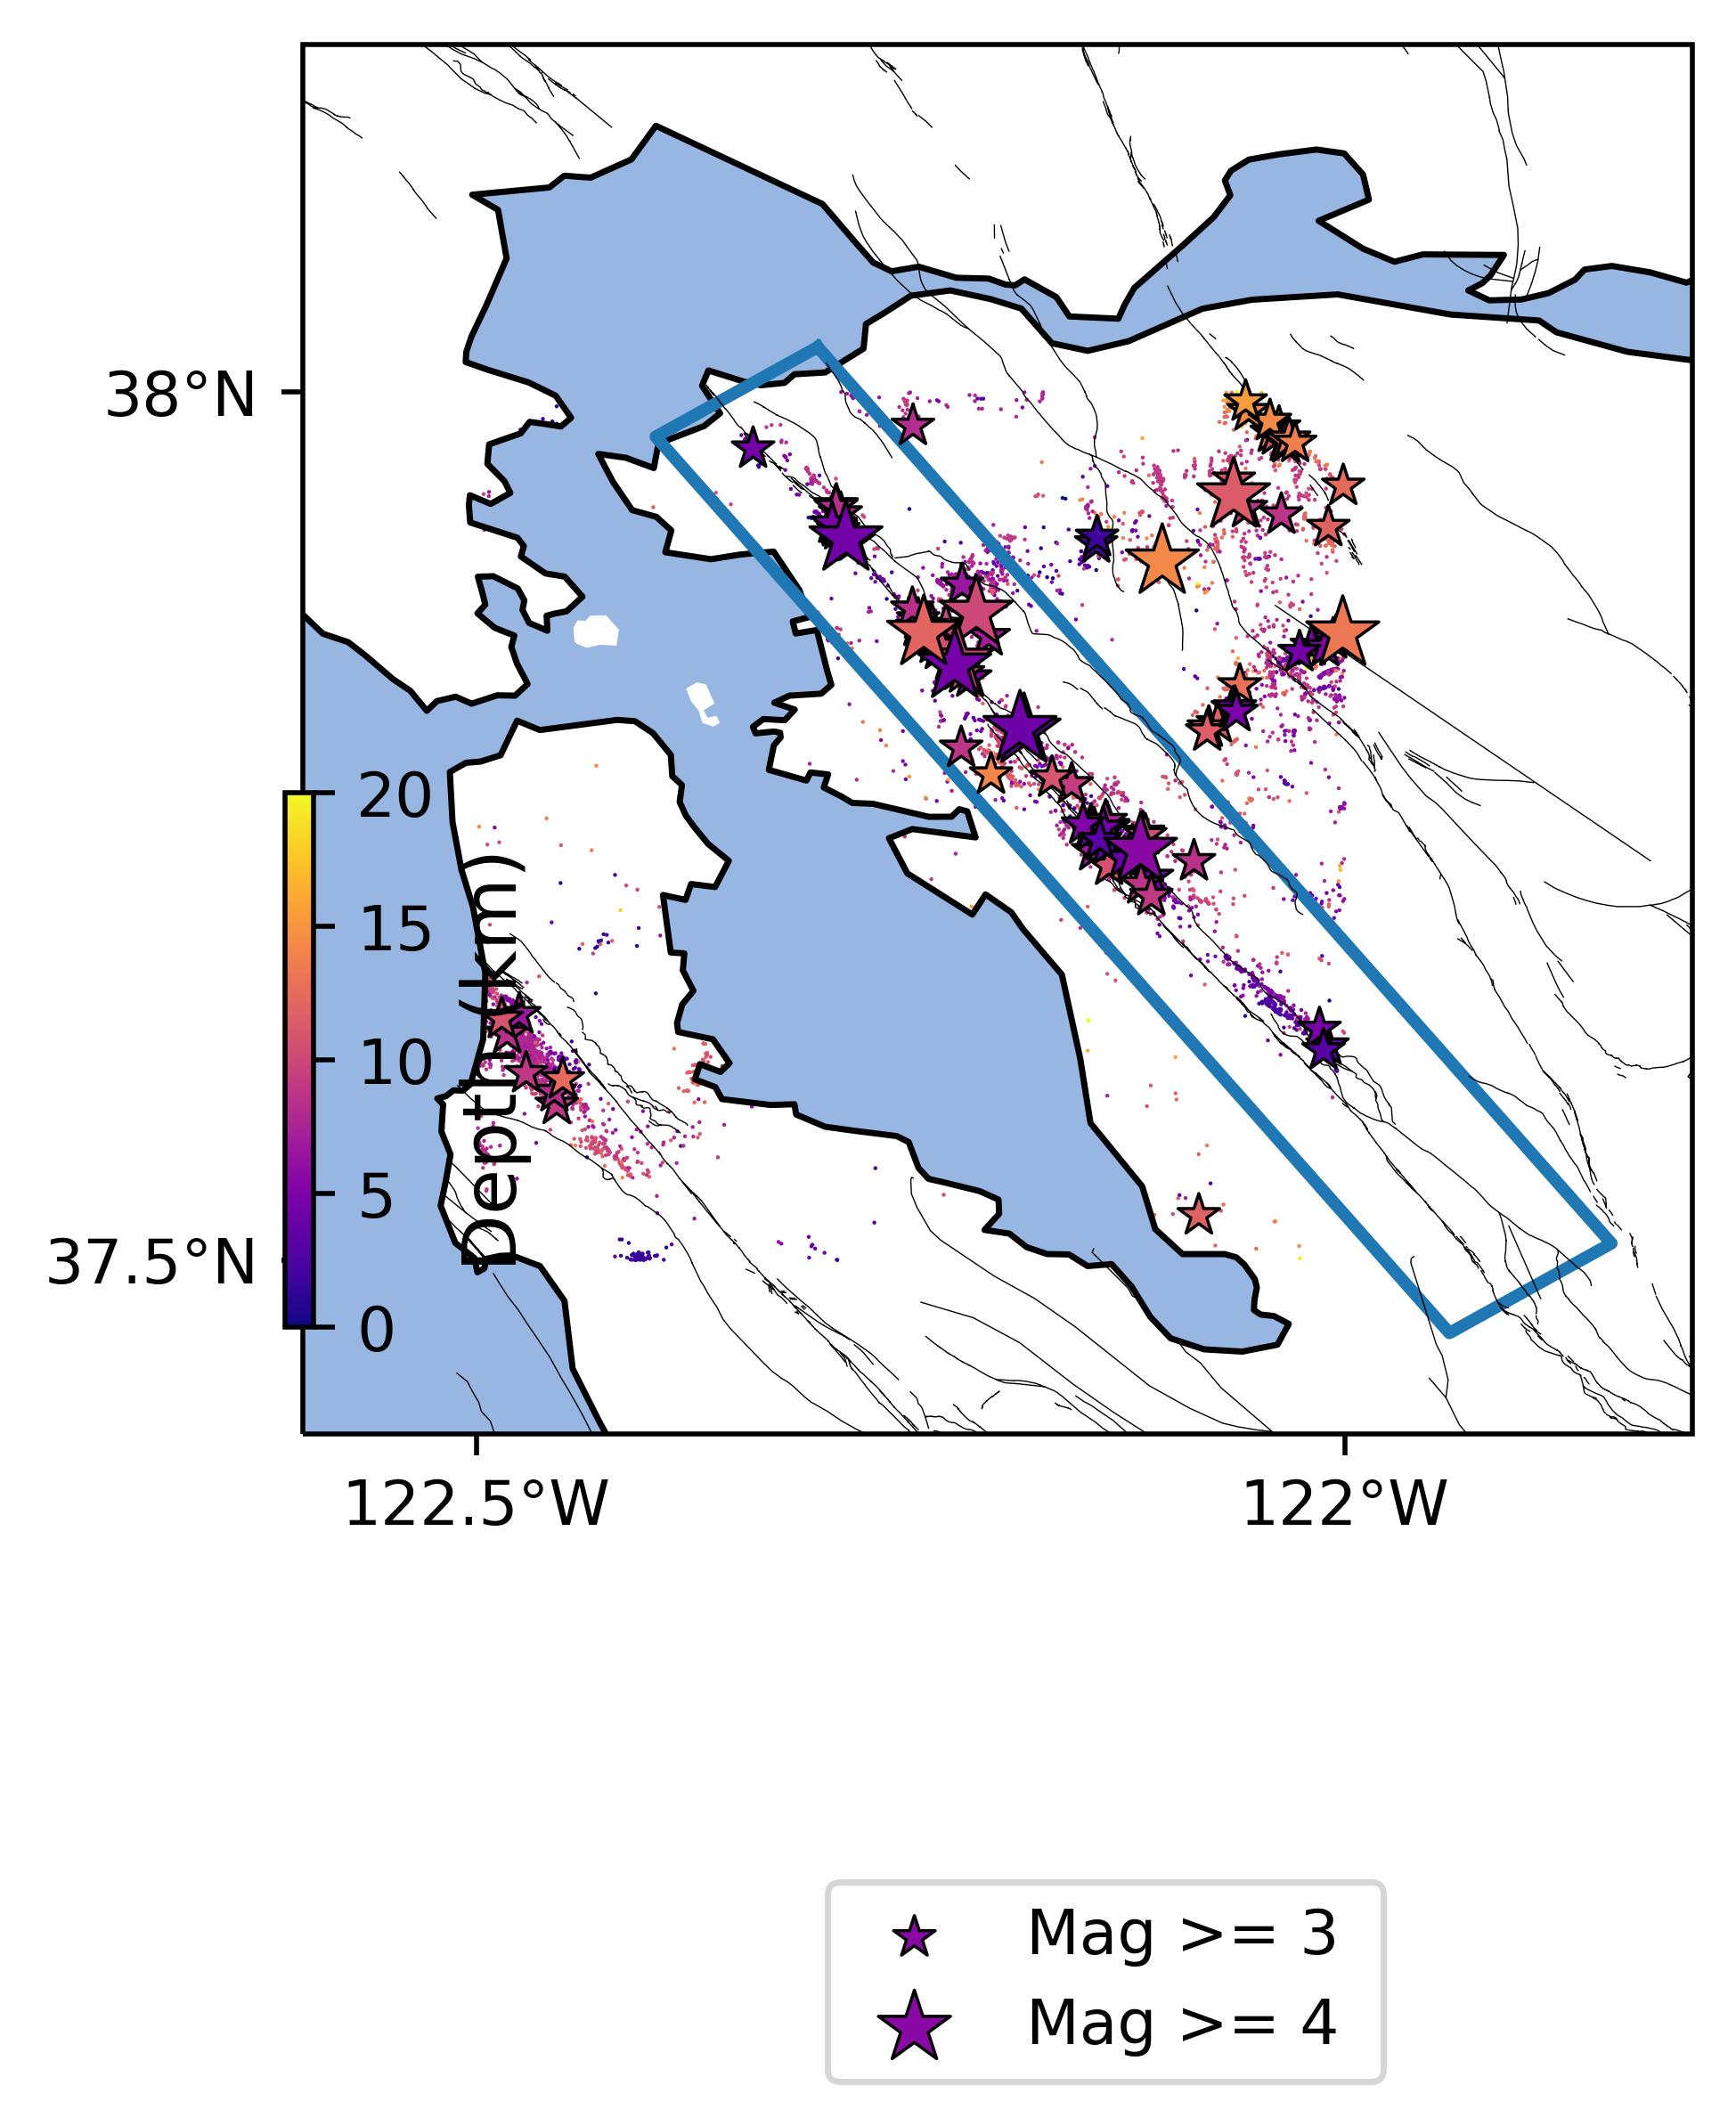

In [7]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

lake_10m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                         linewidth=0.5,
                                        facecolor=cfeature.COLORS['water'])

provinces_10m = cfeature.NaturalEarthFeature('cultural',
                                             'admin_1_states_provinces_lines',
                                             '10m',
                                             facecolor='none')
oceans_10m = cfeature.NaturalEarthFeature('physical',
                                             'ocean',
                                             '10m',
                                             facecolor=cfeature.COLORS['water'])

fig=plt.figure()
ax = fig.add_axes([0, 0, 1, 0.65], projection=ccrs.PlateCarree())
index = np.where(mag>=3)
ax.scatter(lon[index],lat[index],marker='*',s=50,lw=0.5,cmap='plasma',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 3')
index = np.where(mag>=4)
ax.scatter(lon[index],lat[index],marker='*',s=150,lw=0.5,cmap='plasma',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 4 ')
im = ax.scatter(lon,lat,c=dep,s=0.4,edgecolors='none',cmap='plasma', \
               vmin=0,vmax=20)
ax.legend(bbox_to_anchor=(0.8,-0.3))

ax.set_yticks(np.arange(37,38.5+0.1,0.5))
ax.set_xticks(np.arange(-123,-121+0.1,0.5))
ax.plot(qfault[:,1],qfault[:,0],lw=0.2,c='k',zorder=3)


ax.plot(box_coor_proj[:,1],box_coor_proj[:,0],lw=2)
lon_formatter = LongitudeFormatter(number_format='g',dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='g')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(37.4,38.2)
ax.set_xlim(-122.6,-121.8)


ax.add_feature(lake_10m)
ax.add_feature(oceans_10m)
ax.add_feature(provinces_10m)
ax.add_feature(cfeature.BORDERS)
ax.coastlines('10m')

cax1 = fig.add_axes([0.25, 0.05, 0.01, 0.25])
cbar=fig.colorbar(im,cax=cax1,fraction=0.04, pad=0.03,
                  label='Depth (km)',ticks=[0,5,10,15,20])
cbar.set_label(label='Depth (km)',fontsize=12)



# Step 1.4 overview of the selected data

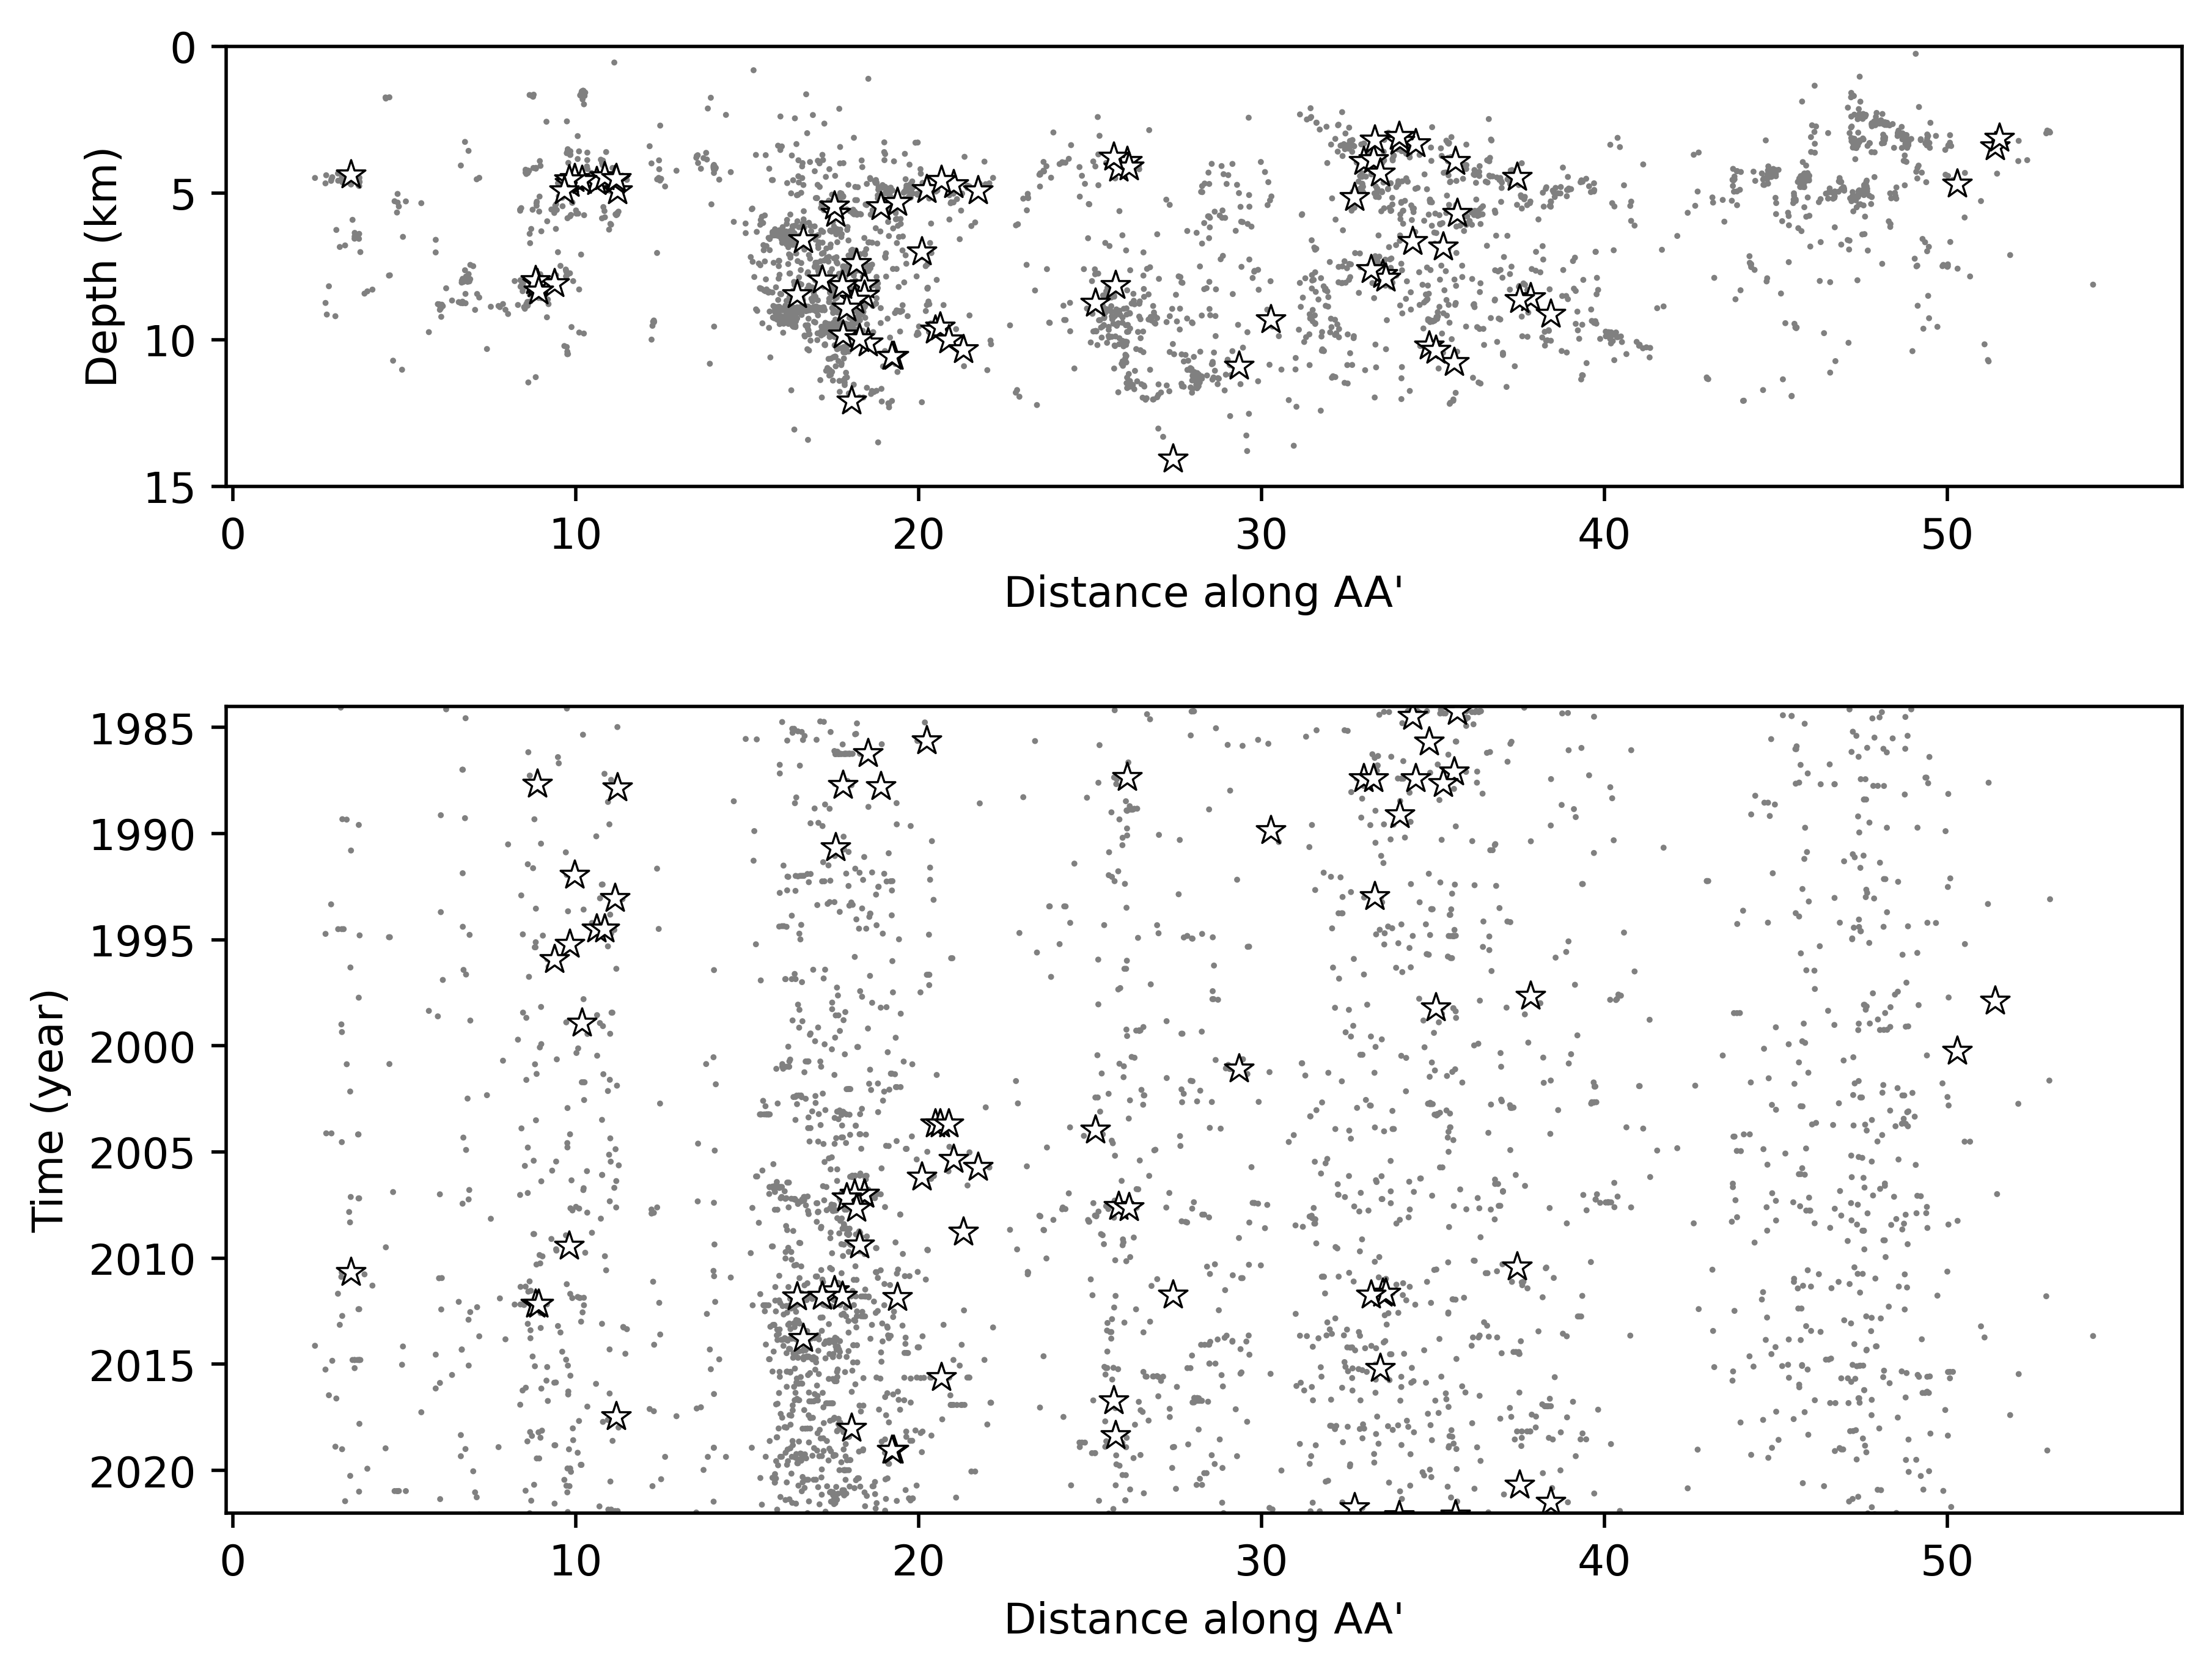

In [8]:

fig = plt.figure()
ax = fig.add_axes([0, 0.7, 1, 0.3])
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]
ax.scatter(dist_along_proj[index],dep[index],c='gray',s=2,edgecolors='none')
index_M = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&
                   (dist_norm_proj<5)&(dist_norm_proj>-5)&(mag>=3))[0]
ax.scatter(dist_along_proj[index_M],dep[index_M],c='w',s=50,edgecolors='k',lw=0.5,marker='*')
ax.set_ylim(15,0)
ax.set_xlabel("Distance along AA'")
ax.set_ylabel("Depth (km)")

ax = fig.add_axes([0, 0, 1, 0.55])
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]
ax.scatter(dist_along_proj[index],time_year[index],c='gray',s=2,edgecolors='none')
index_M = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&
                   (dist_norm_proj<5)&(dist_norm_proj>-5)&(mag>=3))[0]
ax.scatter(dist_along_proj[index_M],time_year[index_M],c='w',s=50,edgecolors='k',lw=0.5,marker='*')
ax.set_ylim(2022,1984)
ax.set_xlabel("Distance along AA'")
ax.set_ylabel("Time (year)")

plt.show()

# Step 2.1 calculate B-value

In [9]:
def calc_Mc_b(mag,plot=0):
    nNumberMagnitude=np.floor(mag.max()*10)+1
    xx=np.linspace(np.floor(mag.min()*10)/10,mag.max(),int((np.floor(mag.max()*10)/10-
                                                            np.floor(mag.min()*10)/10)*10)+1)
    vhist,vMagBins=np.histogram(mag,bins=xx)
    iMc = np.where(vhist==vhist.max())[0][-1]
    fMc=vMagBins[iMc]
    hist = vhist[iMc:][::-1]
    bins = vMagBins[iMc:][::-1]
    cum_hist = hist.cumsum()
    log_cum_sum = np.log10(cum_hist)
    bins = bins[1:]
    b,a = np.polyfit(bins, log_cum_sum, 1)
    if plot==1:
        plt.figure()
        plt.subplot(211)
        plt.bar(vMagBins[:-1]+0.05,vhist,0.1)
        plt.axvline(x=fMc,c='r',lw=2)
        plt.title('Mc:'+ "{:.2f}".format(fMc)+'  '+'b value:'+  "{:.2f}".format(-b))
        plt.xlim(-1,8)
        plt.ylabel('Event number')
        plt.subplot(212)
        plt.plot(bins,np.log10(cum_hist))
        plt.plot(bins,a + b*bins)
        plt.xlim(-1,8)
        plt.xlabel('Magnitude')
        plt.ylabel('log10(CDF)')
        plt.show()
        
    return fMc, a, -b

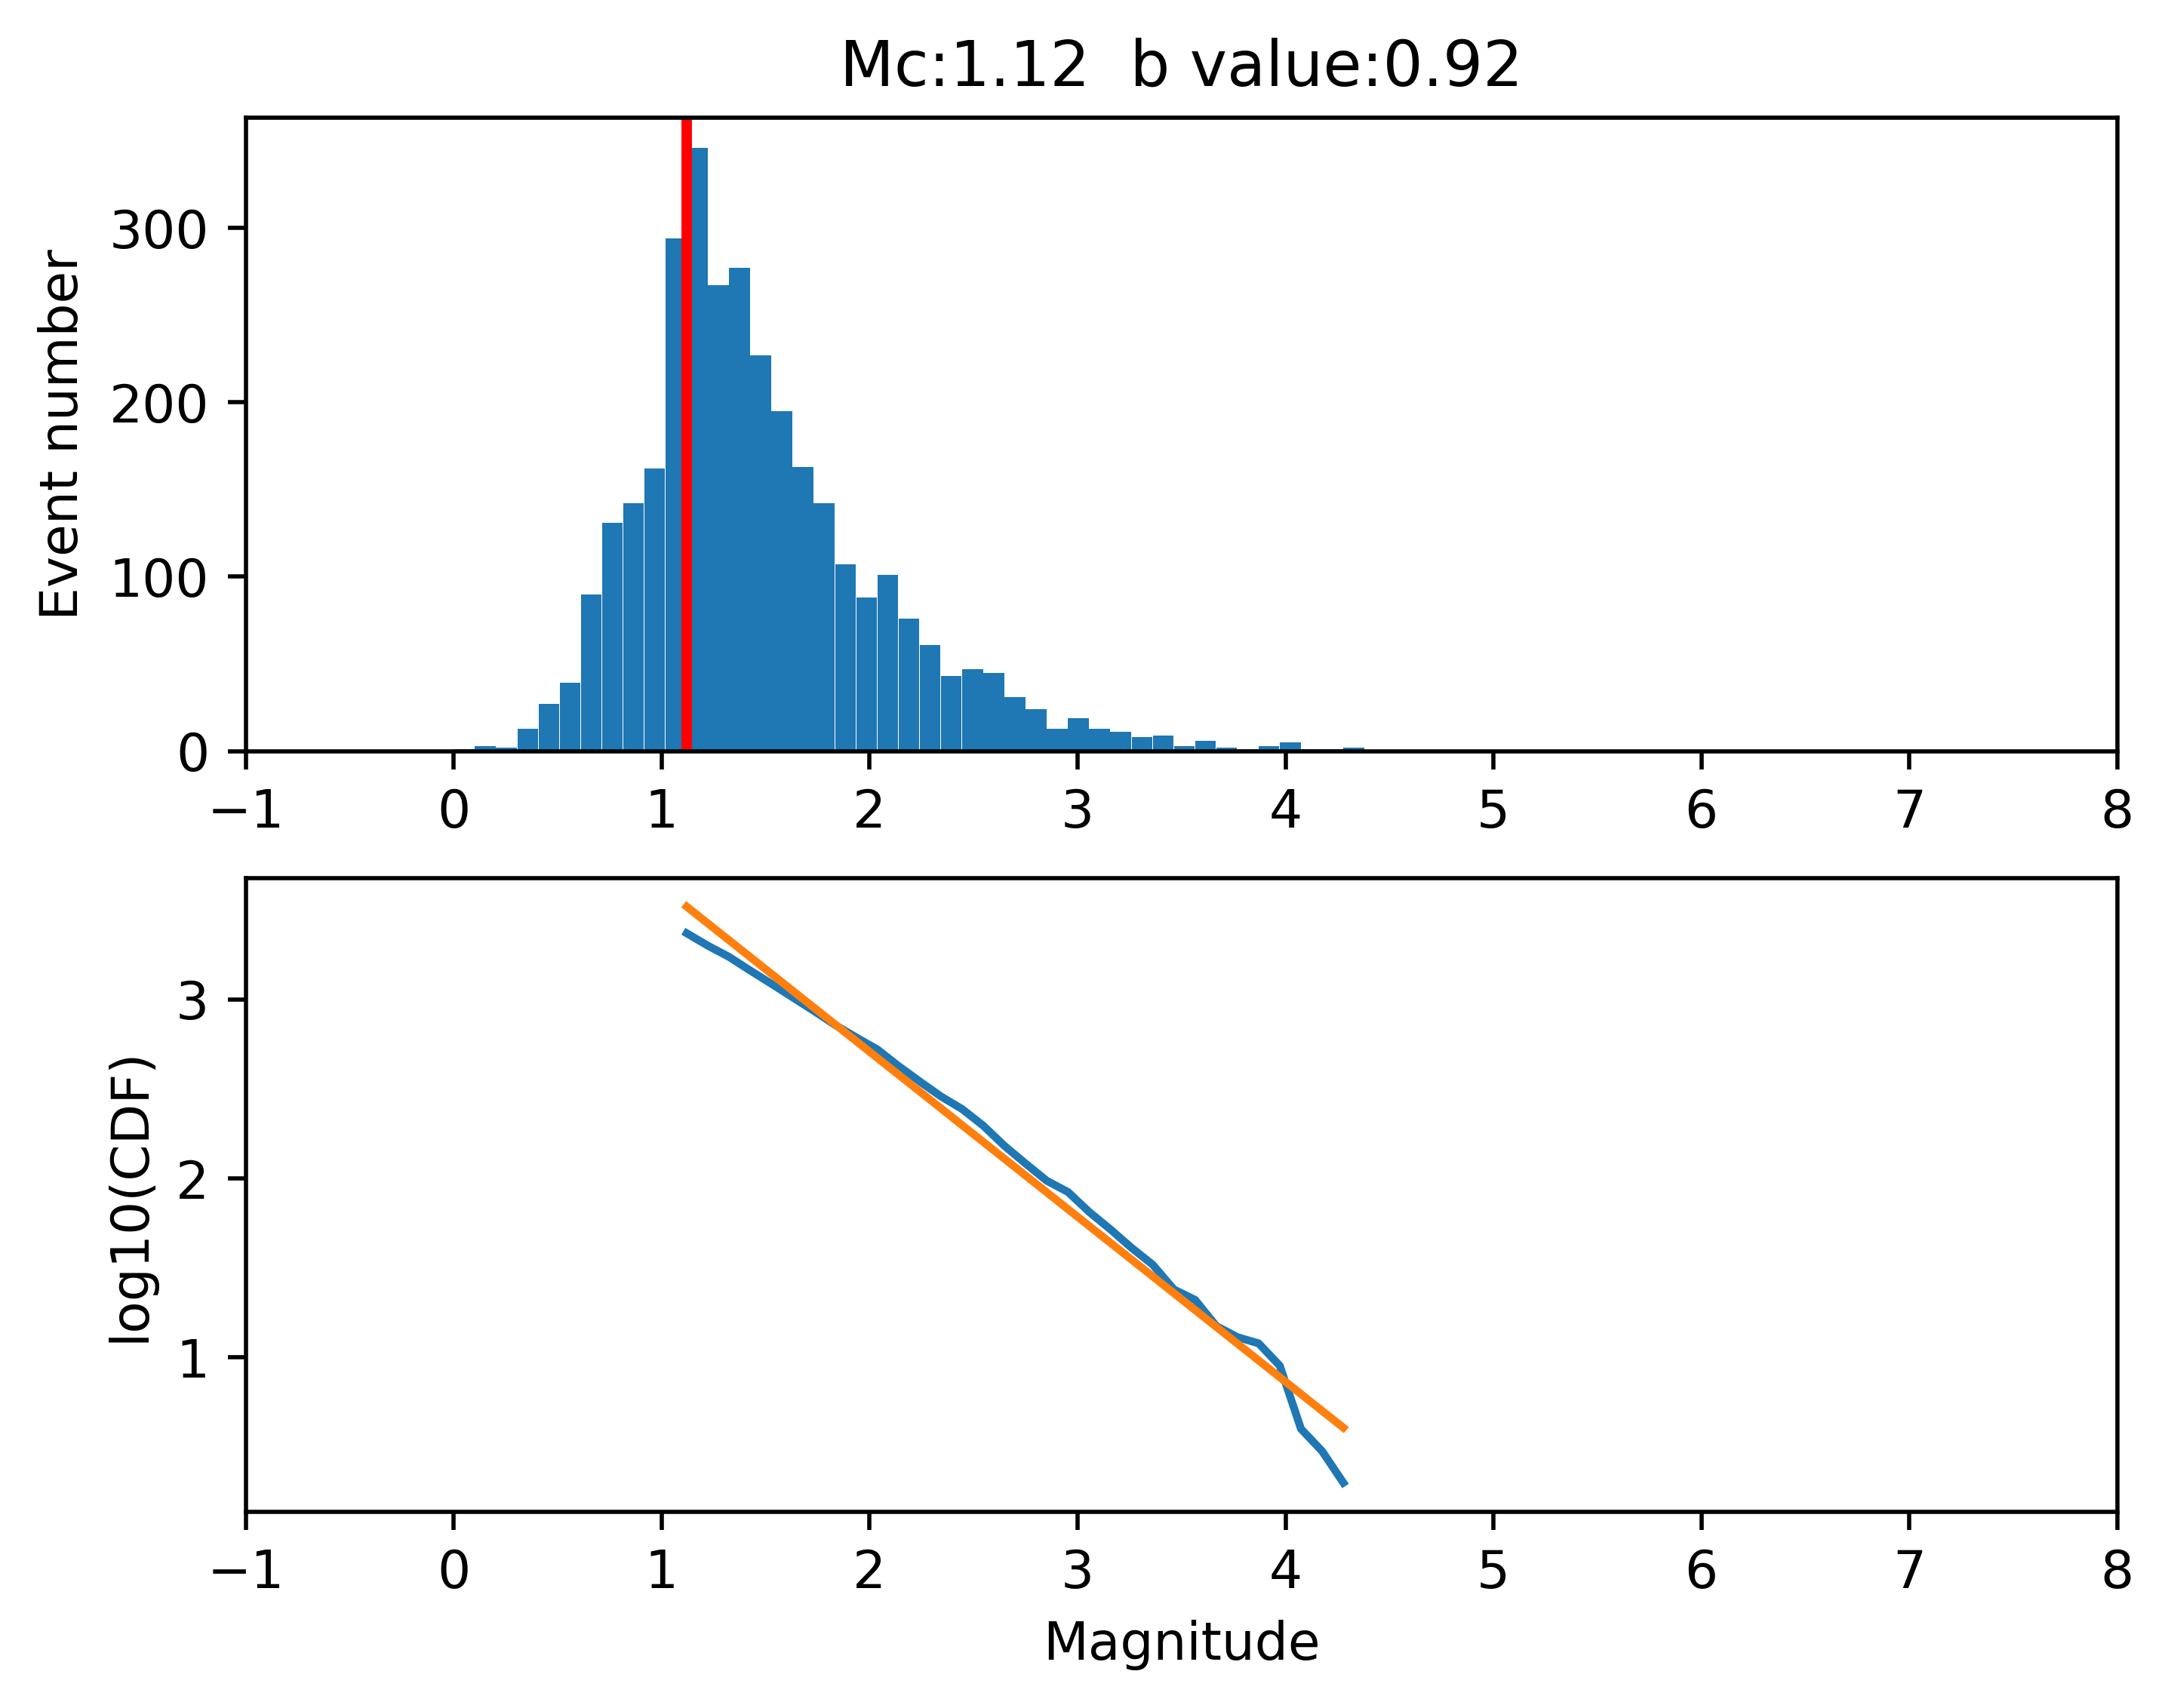

(1.1204651162790698, 4.5493008681768368, 0.92112541401094405)

In [10]:
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]

calc_Mc_b(mag[index],plot=1)

# Step 2.2 calculate B-value in different spatial bins and plot

In [11]:
index1 = np.where((dist_along_proj<15)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]

calc_Mc_b(mag[index1],plot=0)

(1.3, 3.4769503811298161, 0.78650805005719238)

In [12]:
index2 = np.where((dist_along_proj<22)&(dist_along_proj>15)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]

calc_Mc_b(mag[index2],plot=0)

(1.0186046511627906, 4.0121369833826952, 0.8783033347668957)

In [13]:
index3 = np.where((dist_along_proj<25)&(dist_along_proj>22)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]

calc_Mc_b(mag[index3],plot=0)

(1.2066666666666666, 2.5829340107343999, 0.79010934909427188)

In [14]:
index4 = np.where((dist_along_proj<40)&(dist_along_proj>30)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]

calc_Mc_b(mag[index4],plot=0)

(1.2999999999999998, 4.0609642980350289, 0.9434094798578232)

# Step 2.3 calculate B-value in different time window and plot

Prediction: b-value increases slightly after Loma Prieta foreshocks (Jun 27, 1989; Aug 8, 1989) and increases dramatically after main shock (Oct 17, 1989).

Indices:
-01-01-1984 -> 06-26-1989

-06-27-1989 -> 08-07-1989

-08-08-1989 -> 10-16-1989

-10-17-1989 -> 10-20-1989

-10-20-1989 -> present (or look at creep event)

All on southern segment (kilometers 40-70)

In [15]:
lp1 = np.where((dist_along_proj<70)&(dist_along_proj>40)&(dist_norm_proj<5)&(dist_norm_proj>-5)&(time_year>1984)&(time_year<1989.4836)&(mag>=0))[0]

lp2 = np.where((dist_along_proj<70)&(dist_along_proj>40)&(dist_norm_proj<5)&(dist_norm_proj>-5)&(time_year>1989.4836)&(time_year<1989.5986)&(mag>=0))[0]

lp3 = np.where((dist_along_proj<70)&(dist_along_proj>40)&(dist_norm_proj<5)&(dist_norm_proj>-5)&(time_year>1989.5986)&(time_year<1989.7904)&(mag>=0))[0]

lp4 = np.where((dist_along_proj<70)&(dist_along_proj>40)&(dist_norm_proj<5)&(dist_norm_proj>-5)&(time_year>1989.7904)&(time_year<1989.7932)&(mag>=0))[0]

lp5 = np.where((dist_along_proj<70)&(dist_along_proj>40)&(dist_norm_proj<5)&(dist_norm_proj>-5)&(time_year>1989.7932)&(time_year<1989.8014)&(mag>=0))[0]

lp6 = np.where((dist_along_proj<70)&(dist_along_proj>40)&(dist_norm_proj<5)&(dist_norm_proj>-5)&(time_year>1989.8014)&(time_year<1990)&(mag>=0))[0]

print(mag[lp1])
print(mag[lp2])
print(mag[lp3])
print(mag[lp4])
print(mag[lp5])
print(mag[lp6])

LPb1 = (calc_Mc_b(mag[lp1]))[2]
#LPb2 = (calc_Mc_b(mag[lp2]))[2]
LPb3 = (calc_Mc_b(mag[lp3]))[2]
#LPb4 = (calc_Mc_b(mag[lp4]))[2]
#LPb5 = (calc_Mc_b(mag[lp5]))[2]
LPb6 = (calc_Mc_b(mag[lp6]))[2]

print(LPb1)
#print(LPb2)
print(LPb3)
#print(LPb4)
#print(LPb5)
print(LPb6)

print(evid[lp1])

[ 1.58  1.95  1.36  1.04  2.09  2.01  1.11  1.66  2.3   1.12  1.04  0.84
  1.53  1.19  1.22  1.15  0.9   1.19  1.47  1.22  1.25  1.06  1.25  1.21
  1.73  1.22  1.15  1.2   2.    1.2   1.24  1.25  1.58  1.91  1.42  0.87
  1.07  1.11  1.19  0.99  0.96  1.18  1.24  1.13  1.76  1.6   1.08  2.36
  1.17  1.61  1.36  1.45  2.41  1.72  1.15  1.22  1.36  1.2   1.38]
[]
[ 1.27  1.39  1.2 ]
[]
[]
[ 1.26  1.32]
1.0709643173
-0.1988005228
-0.12542916486
[  7441   7699  15086  20115  21015  21044  22080  22490  24360  30880
  44005  48472  48484  50071  50697  51425  59559  61659  62604  62659
  63067  63163  65120  66953  67624  73030  73229  84002  84944  95915
 100348 100354 101625 101651 104197 104270 104741 105040 105285 105330
 105338 106607 106669 106662 107573 112502 112980 114349 116557 117844
 117874 117906 120519 120539 122595 130966 132263 132700 138874]


C:\Users\yair_\AppData\Local\Temp\ipykernel_31888\542253214.py:22: RankWarning: Polyfit may be poorly conditioned
  LPb3 = (calc_Mc_b(mag[lp3]))[2]
C:\Users\yair_\AppData\Local\Temp\ipykernel_31888\542253214.py:25: RankWarning: Polyfit may be poorly conditioned
  LPb6 = (calc_Mc_b(mag[lp6]))[2]


Conclusion: there are not enough earthquakes in such short intervals to determine b-value at Hayward Fault __(save this idea for 109 final project!!! (do it on this segment of San Andreas))__

Next approach: use a loop to find b-value at longer intervals (try 6 months first, then a year, and so on)

In [16]:
#LP_bvals = []

def LPaddbVal(bval,step=0,plot=0):
    global LP_bVals
    LP_bVals.append(bval)
    
    if plot==1:
        xrange = len(LP_bVals)
        x = np.arange(xrange)
        plt.plot(x,LP_bVals,"ro-")
        plt.xlabel(f"Time steps passed ({step} years per time step)")
        plt.ylabel('b-value')
        plt.ylim(0,np.max(LP_bVals)+0.1)

In [17]:
def addbVal(arrayName,bval,startYear=0,step="undefined",plot=0):
    #if plot==0:
    arrayName.append(bval)
    
    if plot==1:
        xrange = len(arrayName)
        x = startYear + np.arange(xrange) #startyear was what changed
        
        a,b = np.polyfit(x,arrayName,1)
        
        bMed = np.median(arrayName)
        YLBuffer = 0.1 * bMed
            
        plt.axhspan(0,bMed-YLBuffer,0,xrange,color="red",alpha=0.5)
        plt.axhspan(bMed-YLBuffer,bMed+YLBuffer,0,xrange,color="yellow",alpha=0.5)
        plt.axhspan(bMed+YLBuffer,np.max(arrayName)+0.5,0,xrange,color="green",alpha=0.5)
        #arbitrary range for colors for now, need to read up more on how to choose these.
        
        plt.axhline(y = bMed, color = 'black', linestyle = '--',label=f"Median ({np.around(bMed,3)})")
        plt.plot(x,arrayName,'b.:',label="b-value trend")
        #plt.plot(x,a*x+b,'r',label=f"Best fit line")
        
        #TODO: make x-axis show calendar years instead of time steps to make time tracking easier
        
        plt.xlabel(f"Year ({step} years per time step)")
        plt.ylabel('b-value')
        plt.legend()
        plt.ylim(0,np.max(arrayName)+0.5)
        #plt.xticks(x)
        #plt.rc('xtick', labelsize=3)

In [27]:
def addbVal_slide(arrayName,bval,dates,firstEQ=0,lastEQ=1,plot=0): #adds b values to given array and can also plot
    if plot==0:
        arrayName.append(bval)
    
    elif plot==1:
        xrange = len(arrayName)
        x = dates #startyear was what changed
        
        print(len(x),len(arrayName))
        
        a,b = np.polyfit(x,arrayName,1)
        
        bMed = np.median(arrayName)
        YLBuffer = 0.1 * bMed
            
        plt.axhspan(0,bMed-YLBuffer,0,xrange,color="red",alpha=0.5)
        plt.axhspan(bMed-YLBuffer,bMed+YLBuffer,0,xrange,color="yellow",alpha=0.5)
        plt.axhspan(bMed+YLBuffer,np.max(arrayName)+0.5,0,xrange,color="green",alpha=0.5)
        #arbitrary range for colors for now, need to read up more on how to choose these.
        
        plt.axhline(y = bMed, color = 'black', linestyle = '--',label=f"Median ({np.around(bMed,3)})")
        plt.plot(x,arrayName,'b-',label="b-value trend")
        #plt.plot(x,a*x+b,'r',label=f"Best fit line")
        
        #TODO: convert event id to year and mark on x-axis
        
        plt.xlabel(f"Year")
        plt.ylabel('b-value')
        plt.legend()
        plt.ylim(0,2)
        plt.xticks(np.arange(np.around(firstEQ), np.around(lastEQ), step=3))  # Set label locations.
        #plt.xticks([0,1,2],[firstEQ,"middle",lastEQ])
        #plt.rc('xtick', labelsize=3)

test = []
b = 12
c = 14

addbVal(test,b)

print(test)

addbVal(test,c)

print(test)

addbVal(test,19,2,1)

bvalue_test_2 = [12,14,154,16,78,90]

#addbVal(bvalue_test_2,0,1.3,1)

In [19]:
LP_bVals = []
yearStep = 8 #how many years per iteration
#print("time step:",yearStep,"years per iteration.")
its = 100
present = 2022


for i in range(its):
    index = 0
    timeStart = 1984+(i*yearStep)
    timeEnd = 1984+((i+1)*yearStep)
    
    #if timeStart>present: addbVal(bvalSet,plot=1); break
    
    areaParams = (dist_along_proj<70)&(dist_along_proj>32)&(dist_norm_proj<5)&(dist_norm_proj>-5) #default area parameters
    #print("set",i,"on time interval",timeStart,"-",timeEnd)
    timeParams = (time_year>timeStart)&(time_year<timeEnd)
    
    index = np.where(areaParams&timeParams)
    #print(timeStart, mag[index])
    
    bvalSet = (calc_Mc_b(mag[index]))[2]
    
    if i==its or timeStart+yearStep>present:
        addbVal(LP_bVals,bvalSet,yearStep,1)
        break
    else: addbVal(LP_bVals,bvalSet)

## Loma Prieta attempt

In [20]:
LP2_bVals = []
yearStep = 0.5 #how many years per iteration
#print("time step:",yearStep,"years per iteration.")
its = 100
present = 2022


for i in range(its):
    index = 0
    timeStart = 1984+(i*yearStep)
    timeEnd = 1984+((i+1)*yearStep)
    
    #if timeStart>present: addbVal(bvalSet,plot=1); break
    
    areaParams = (dist_along_proj<70)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5) #default area parameters
    #print("set",i,"on time interval",timeStart,"-",timeEnd)
    timeParams = (time_year>timeStart)&(time_year<timeEnd)
    
    index = np.where(areaParams&timeParams)
    #print(timeStart, mag[index])
    
    bvalSet = (calc_Mc_b(mag[index]))[2]
    
    if i==its or timeStart+yearStep>present:
        addbVal(LP2_bVals,bvalSet,yearStep,1)
        break
    else: addbVal(LP2_bVals,bvalSet)

## 2011 swarm attempt

In [21]:
Berkeley_seg = []
yearStep = 1 #how many years per iteration (can be x/365 where x is days per step [UNSTABLE])
#print("time step:",yearStep,"years per iteration.")
steps = 100
present = 2022
startYear = 2005 #can also be a decimal of a year


for i in range(steps):
    index = 0
    timeStart = startYear+(i*yearStep)
    timeEnd = startYear+((i+1)*yearStep)
    
    #if timeStart>present: addbVal(bvalSet,plot=1); break
    
    areaParams = (dist_along_proj<23)&(dist_along_proj>13)&(dist_norm_proj<5)&(dist_norm_proj>-5) #default area parameters
    #print("set",i,"on time interval",timeStart,"-",timeEnd)
    timeParams = (time_year>timeStart)&(time_year<timeEnd)
    
    index = np.where(areaParams&timeParams)
    #print(index)
    #print(timeStart, mag[index])
    
    bvalSet = (calc_Mc_b(mag[index]))[2]
    
    if i==steps or timeStart+yearStep>present:
        addbVal(Berkeley_seg,bvalSet,startYear,yearStep,0)
        break
    else: addbVal(Berkeley_seg,bvalSet)

## Attempt using sliding event window
(instead of time intervals [steps])

In [22]:
# Berk_seg = []
# windowSize = 100 #how many events per time window (higher the better)
# windows = 100000 #how many time windows (could be a lot! essentially number of earthquakes)
# timeEnd = 2023
# timeStart = 1983 #can also be a decimal of a year

# areaParams = (dist_along_proj<23)&(dist_along_proj>13)&(dist_norm_proj<5)&(dist_norm_proj>-5) #default area parameters
# timeParams = (time_year>timeStart)
# #print("set",i,"on time interval",timeStart,"-",timeEnd)
# index = np.where(areaParams&timeParams) #[0] Gives only event IDs
# print("selected EQs",index,"# of eqs:",len(index))

# dates = []

# for i in range(windows):
#     currentWindow = index[0][i:i+windowSize]
#     bvalDate = np.max(time_year[currentWindow])
#     dates.append(bvalDate)
#     #print("b value date:",bvalDate)
#     #print("window 1 full, calculating b-value...",currentWindow)
#     bvalSet = (calc_Mc_b(mag[currentWindow]))[2]
#     #print(bvalSet)
#     if i>=windows-1 or len(currentWindow)<windowSize:
#         timeStart = np.min(dates)
#         timeEnd = np.max(dates)
#         addbVal_slide(Berk_seg,bvalSet,dates,timeStart,timeEnd,1)
#         #print(f"calculations finished...plotting")
#         break
#     else: 
#         addbVal_slide(Berk_seg,bvalSet,dates)
#         #print(f"b-value stored")
#         continue

selected EQs (array([  91,   93,   94, ..., 7699, 7704, 7725], dtype=int64),) # of eqs: 1
1126 1125


TypeError: expected x and y to have same length

## Sliding time window approach (buggy!)

time window in years:2.73972602739726
6727
b value date: 1986.7639067827245, value: 0.8192032079930393
b value date: 2005.3879402565321, value: 0.9953624481431544
b value date: 2015.3026688264206, value: 1.1999588184745884
2940 2939


TypeError: expected x and y to have same length

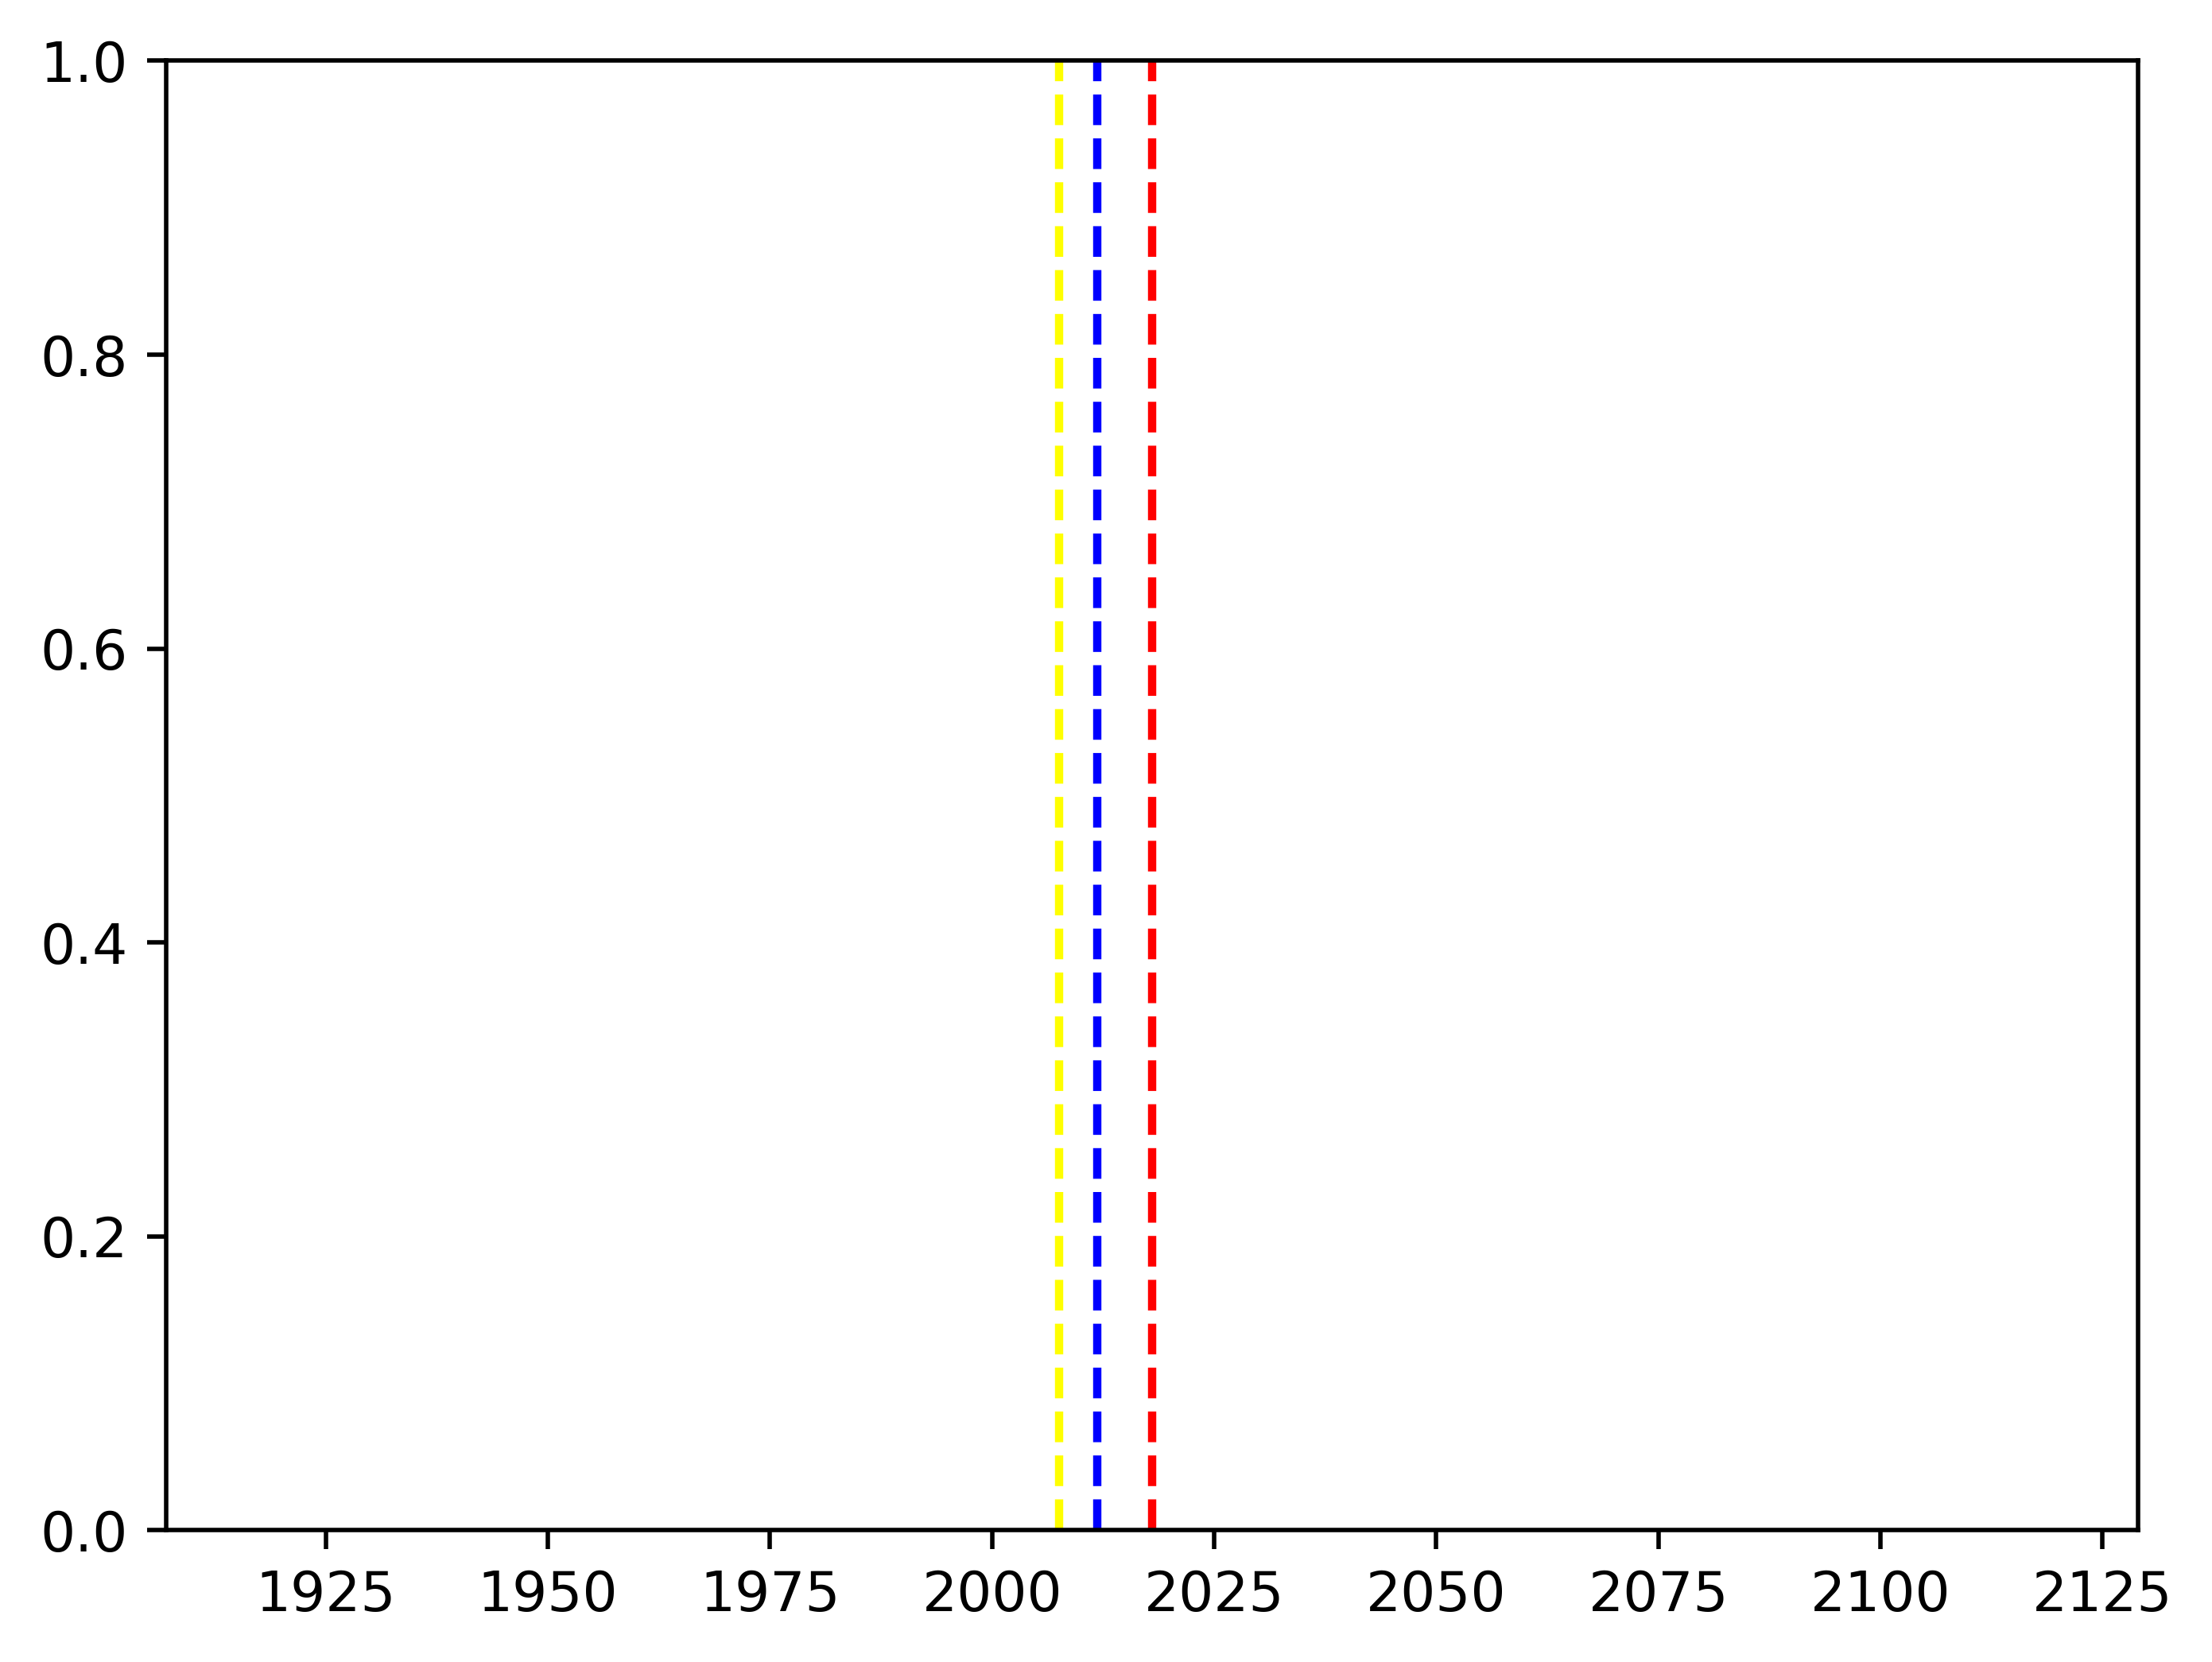

In [23]:
# B_seg = []
# days = 1000
# timeWindow = days / 365 #in days, as decimal of a year
# print(f"time window in years:{timeWindow}")
# windows = len(time_year)-days #how many time windows (could be a lot! essentially number of earthquakes)
# print(windows)
# timeEnd = 2023 #ends after last date of catalog collected. In the far future this number should change!
# timeStart = 1984 #can also be a decimal of a year

# areaParams = (dist_along_proj<70)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5) #area of mapped polygon
# timeParams = (time_year>timeStart)
# #print("set",i,"on time interval",timeStart,"-",timeEnd)
# index = np.where(areaParams&timeParams) #[0] Gives only event IDs
# #print("selected EQs",index,"# of eqs:",len(index[0]))
# #print(time_year[index][0])

# dates = []

# plt.axvline(x = 2018.004, color='red', linestyle='--', label='2018 Berkeley earthquake (M4.4)')
# plt.axvline(x = 2011.8014, color='blue', linestyle='--', label='2011 Berkeley earthquake swarm')
# plt.axvline(x = 2007.5493, color='yellow', linestyle='--', label='2007 Oakland Hills earthquake (M4.2)')

# #plt.axvline(x = decimal date, color='red', linestyle='--', label='event name')

# for i in range(windows):
#     currentWindow = 0
#     FDWindow = time_year[index][i] #first of window
#     #print(FDWindow)
#     wTParams = (time_year>FDWindow)&(time_year<FDWindow+timeWindow)
#     currentWindow = np.where(wTParams)

#     bvalDate = np.max(time_year[currentWindow])
#     dates.append(bvalDate)
    
#     if i%1000==0:
#         #print(f'calculation {i}: earthquakes within {days} days: {time_year<FDWindow+timeWindow}, current array: {currentWindow}')
#         #print("window 1 full, calculating b-value...",currentWindow)
#         #print(bvalSet)
#         print(f"b value date: {bvalDate}, value: {bvalSet}")
#     bvalSet = (calc_Mc_b(mag[currentWindow]))[2]
    
#     if bvalDate>=timeEnd:
#         timeStart = np.min(dates)
#         timeEnd = np.max(dates)
#         addbVal_slide(B_seg,bvalSet,dates,timeStart,timeEnd,1)
#         #print(f"calculations finished...plotting")
#         break
#     else: 
#         addbVal_slide(B_seg,bvalSet,dates)
#         #print(f"b-value stored {B_seg,bvalSet,dates}")
#         continue
        
# plt.legend(fontsize='x-small')

Approach:
-you have a whole list of earthquake dates
-indeces match magnitudes
-dates are decimals, pick a window size (ex: 500 days)
-take all mags from that window
-calculate b value, store in array
-b value date is highest in window
-shift window over by a given interval (1 day, could be more, but doesn't have to)
-repeat step 4 until the b value date is more than or equal to the highest overall date
-plot

## This one works! I think.

7116
0 1997.74738642
2000 2008.70629053
4000 2019.66519464
end of loop, steps: 4617 out of 7116 needed; date of last eq: 2023.0460165593906; last b: 1.0634621884391078
x range: 1997.7473864224044 to 2023.0460165593906; array lengths: (4618, 4618)
4618 4618


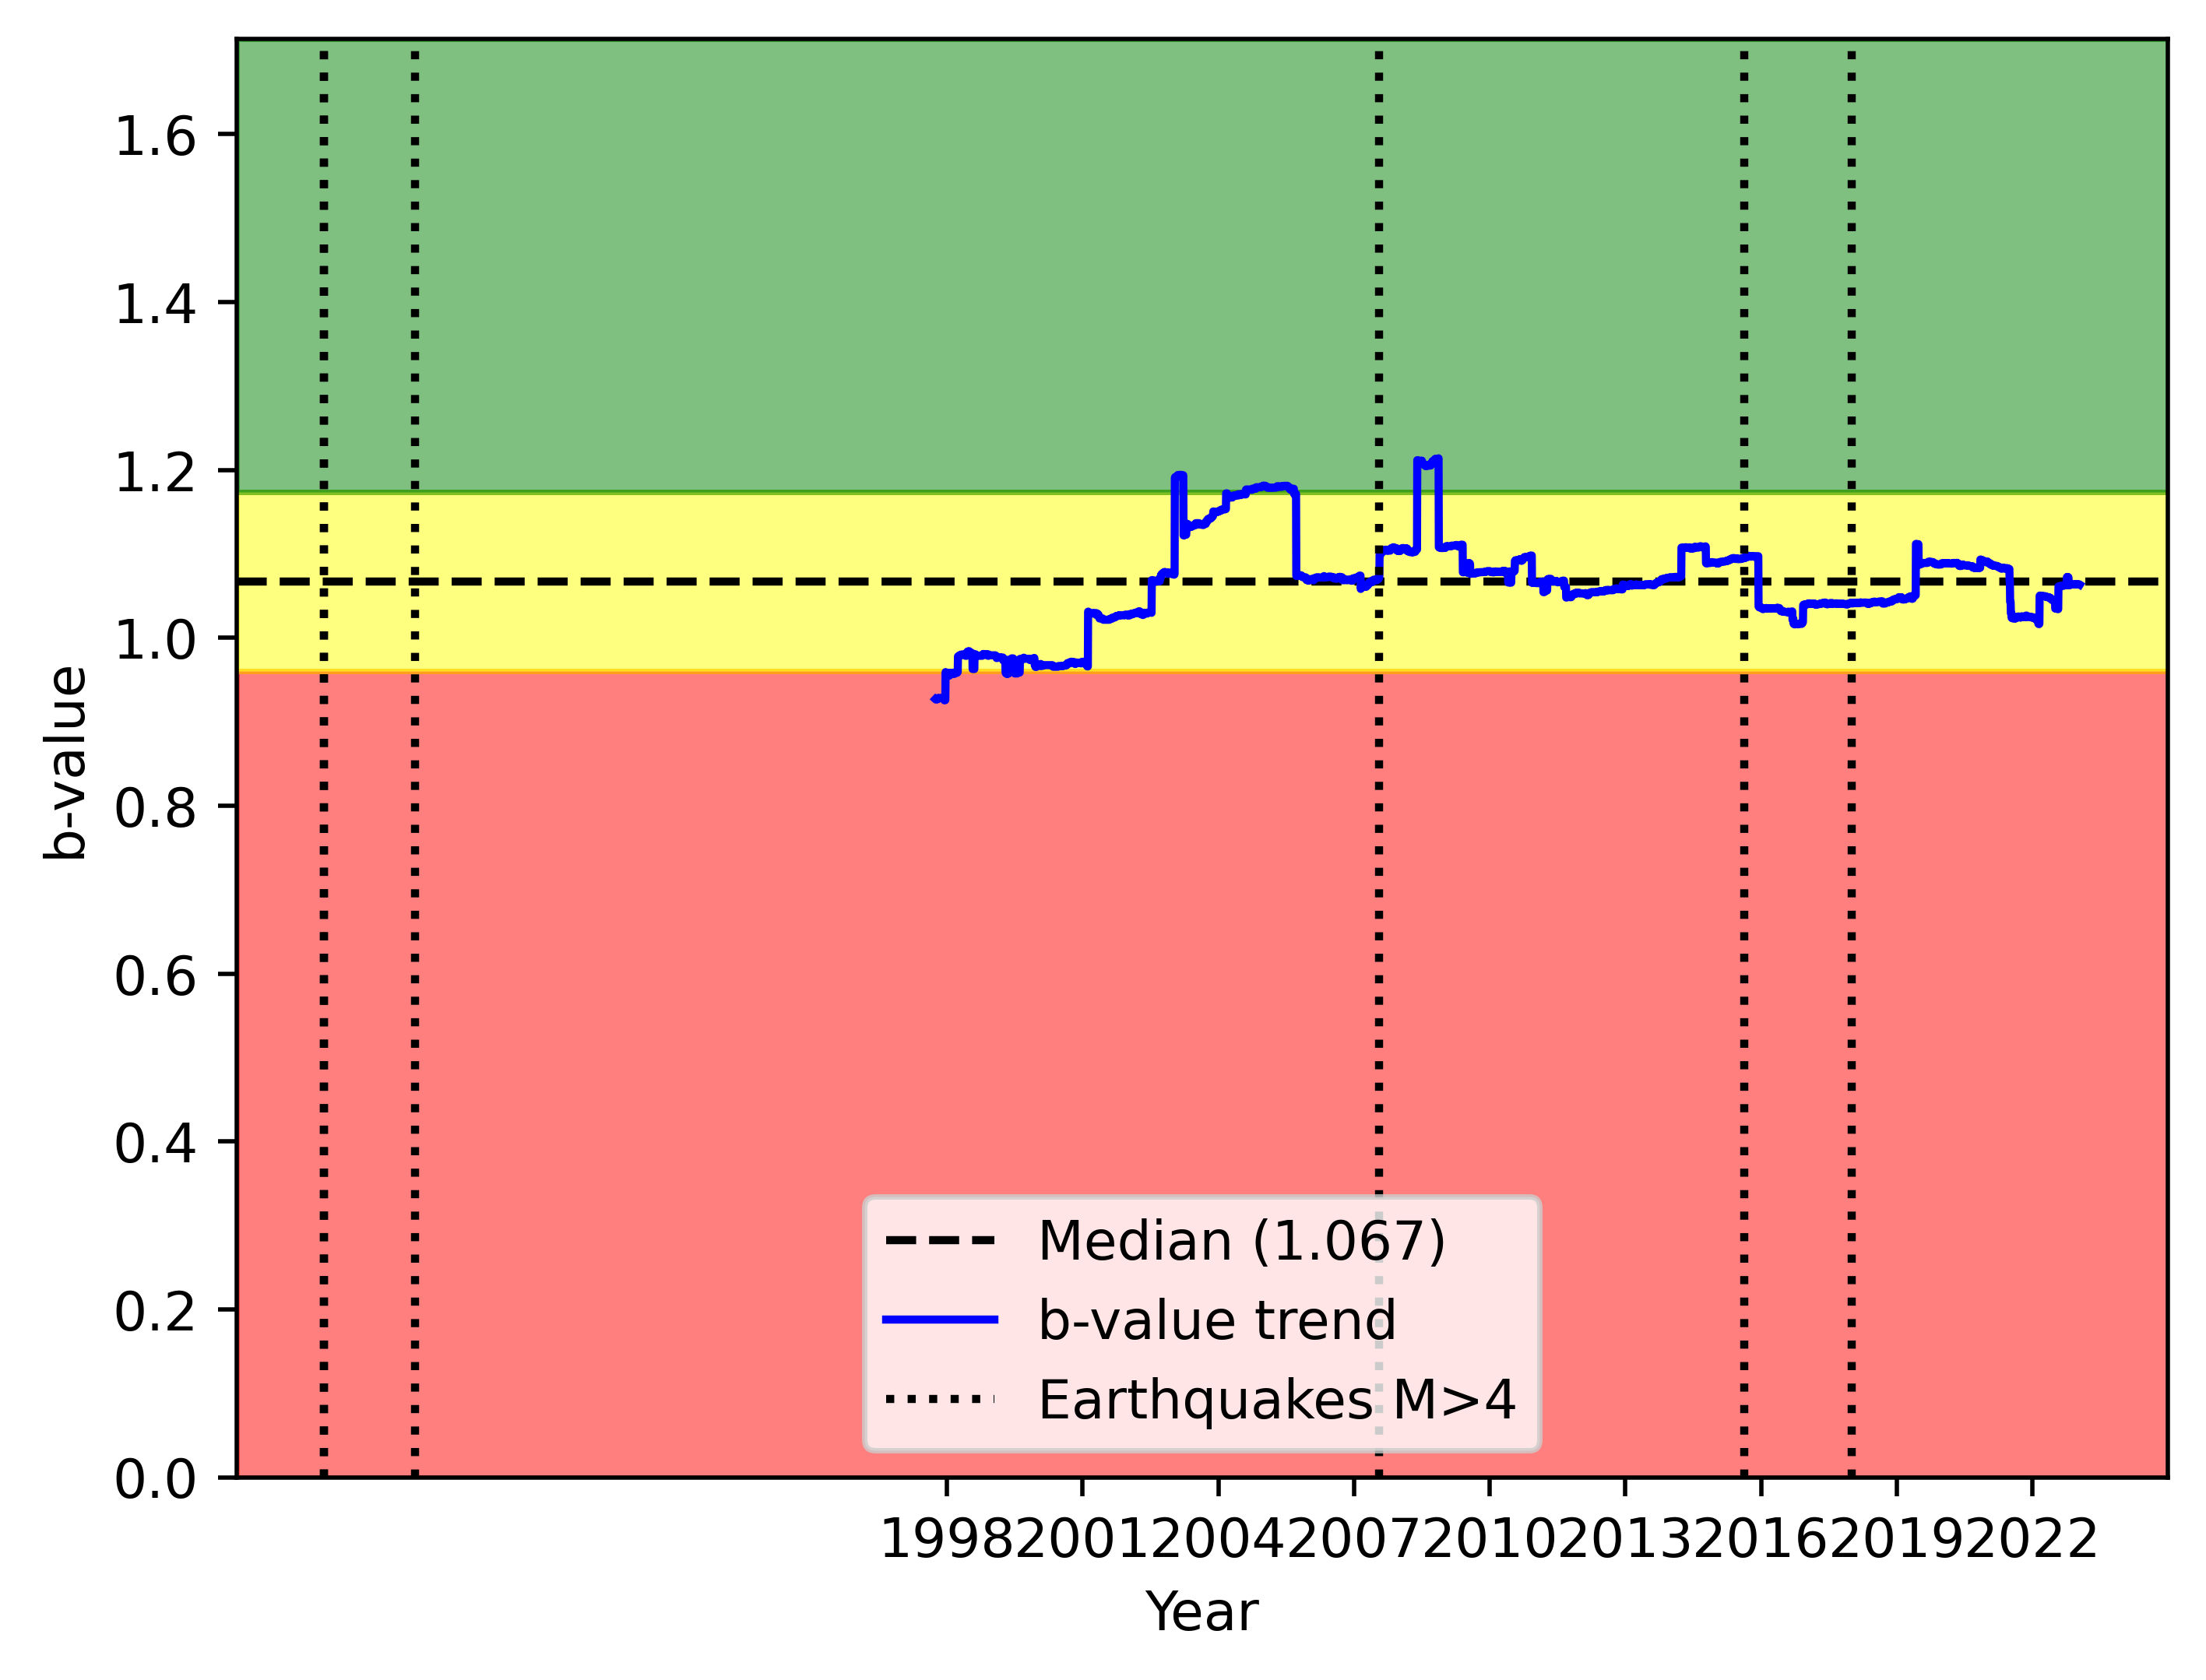

In [24]:
slideAtt = []
bDates = []

timeStart = np.min(time_year)
timeEnd = np.max(time_year) #or custom decimal year dates
timeTotal = timeEnd - timeStart

areaParams = (dist_along_proj<70)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5)
timeParams = (time_year>timeStart)&(time_year<timeEnd)

data = np.where(areaParams&timeParams)
index = data[0]

windowSize = 5000 #in days
wsYears = windowSize / 365
inc = 2 #time increment per loop in days
incYears = inc / 365
steps = int(timeTotal/incYears)

print(steps)

for i in range(steps):
    wCurrent = 0
    wStart = timeStart + incYears * i
    wEnd = wStart + wsYears
    wParams = (time_year[index]>wStart)&(time_year[index]<=wEnd)
    w = np.where(wParams)[0]
    
    bDates.append(wEnd)
    
    bW = calc_Mc_b(mag[w])[2]
    addbVal_slide(slideAtt,bW,bDates)
    
    if i%2000 == 0:
        print(i,wEnd)
        
    if wEnd >= timeEnd:
        print(f"end of loop, steps: {i} out of {steps} needed; date of last eq: {wEnd}; last b: {bW}")
        xMin = np.min(bDates)
        xMax = np.max(bDates)
        print(f"x range: {xMin} to {xMax}; array lengths: {len(slideAtt),len(bDates)}")
        addbVal_slide(slideAtt,bW,bDates,xMin,xMax,1)
        break
        
bigMag = 4
bigEqs = np.where(areaParams&timeParams&(mag>bigMag))
bigDates = time_year[bigEqs]

for x in bigDates:
    if x == min(bigDates):
        plt.axvline(x, color='black', linestyle=':',label=f'Earthquakes M>{bigMag}')
    plt.axvline(x, color='black', linestyle=':')

plt.legend()
#plt.axvline(x = 2018.004, color='red', linestyle='--', label='2018 Berkeley earthquake (M4.4)')
#plt.axvline(x = 2011.8014, color='purple', linestyle='--', label='2011 Berkeley earthquake swarm')
#plt.axvline(x = 2007.5493, color='yellow', linestyle='--', label='2007 Oakland Hills earthquake (M4.2)')
#plt.axvline(x = 1989.7932, color='gray', linestyle='--', label='1989 Loma Prieta earthquake (M7.0, distant)')

In [ ]:
index = 0
areaParams = (dist_along_proj<23)&(dist_along_proj>13)&(dist_norm_proj<5)&(dist_norm_proj>-5) #default area parameters
timeParams = (time_year>timeStart)
print("set",i,"on time interval",timeStart,"-",timeEnd)
index = np.where(areaParams&timeParams)[0]

print(len(index))

for j in range(50):
    print(index[j:j+50])
    if j+50 >= len(index):
        break

In [ ]:
bigEqs = np.where(areaParams&timeParams&(mag>4))
bigDates = time_year[bigEqs]

for x in bigDates:
    plt.axvline(x, color='red', linestyle='--')

plt.legend(['','','','','First line'])


areaParams = (dist_along_proj<70)&(dist_along_proj>40)&(dist_norm_proj<5)&(dist_norm_proj>-5) #default area parameters
timeParams = (time_year>1984.0)&(time_year<1984.5)
EQset = np.where(defParams&timeParams)
print(mag[EQset])

calc_Mc_b(mag[EQset],0)

LP_bvals = [1.02,1.03,1.02,0.9,0.94,0.92,0.6,0.7,0.9,0.7]
its = len(LP_bvals)
x = np.arange(its)
print(yrs,x)
plt.plot(x,LP_bvals)
plt.xlabel('Iteration')
plt.ylabel('b-value')


In [ ]:
print(time_year[3217])
print(time_year)
L = len(time_year)
print(L)
print(np.min(time_year))

1995
(array([   1,    2,    3, ..., 1298, 1299, 1300], dtype=int64),)
[   1    2    3 ..., 1298 1299 1300]
3997
end of loop, steps: 3633 out of 3997 needed; date of last eq: 1995.0021809429522; last b: 0.8194078936360178
x range: 1985.0376262506343 to 1994.9848867370624; array lengths: (3634, 3634)
3634 3634


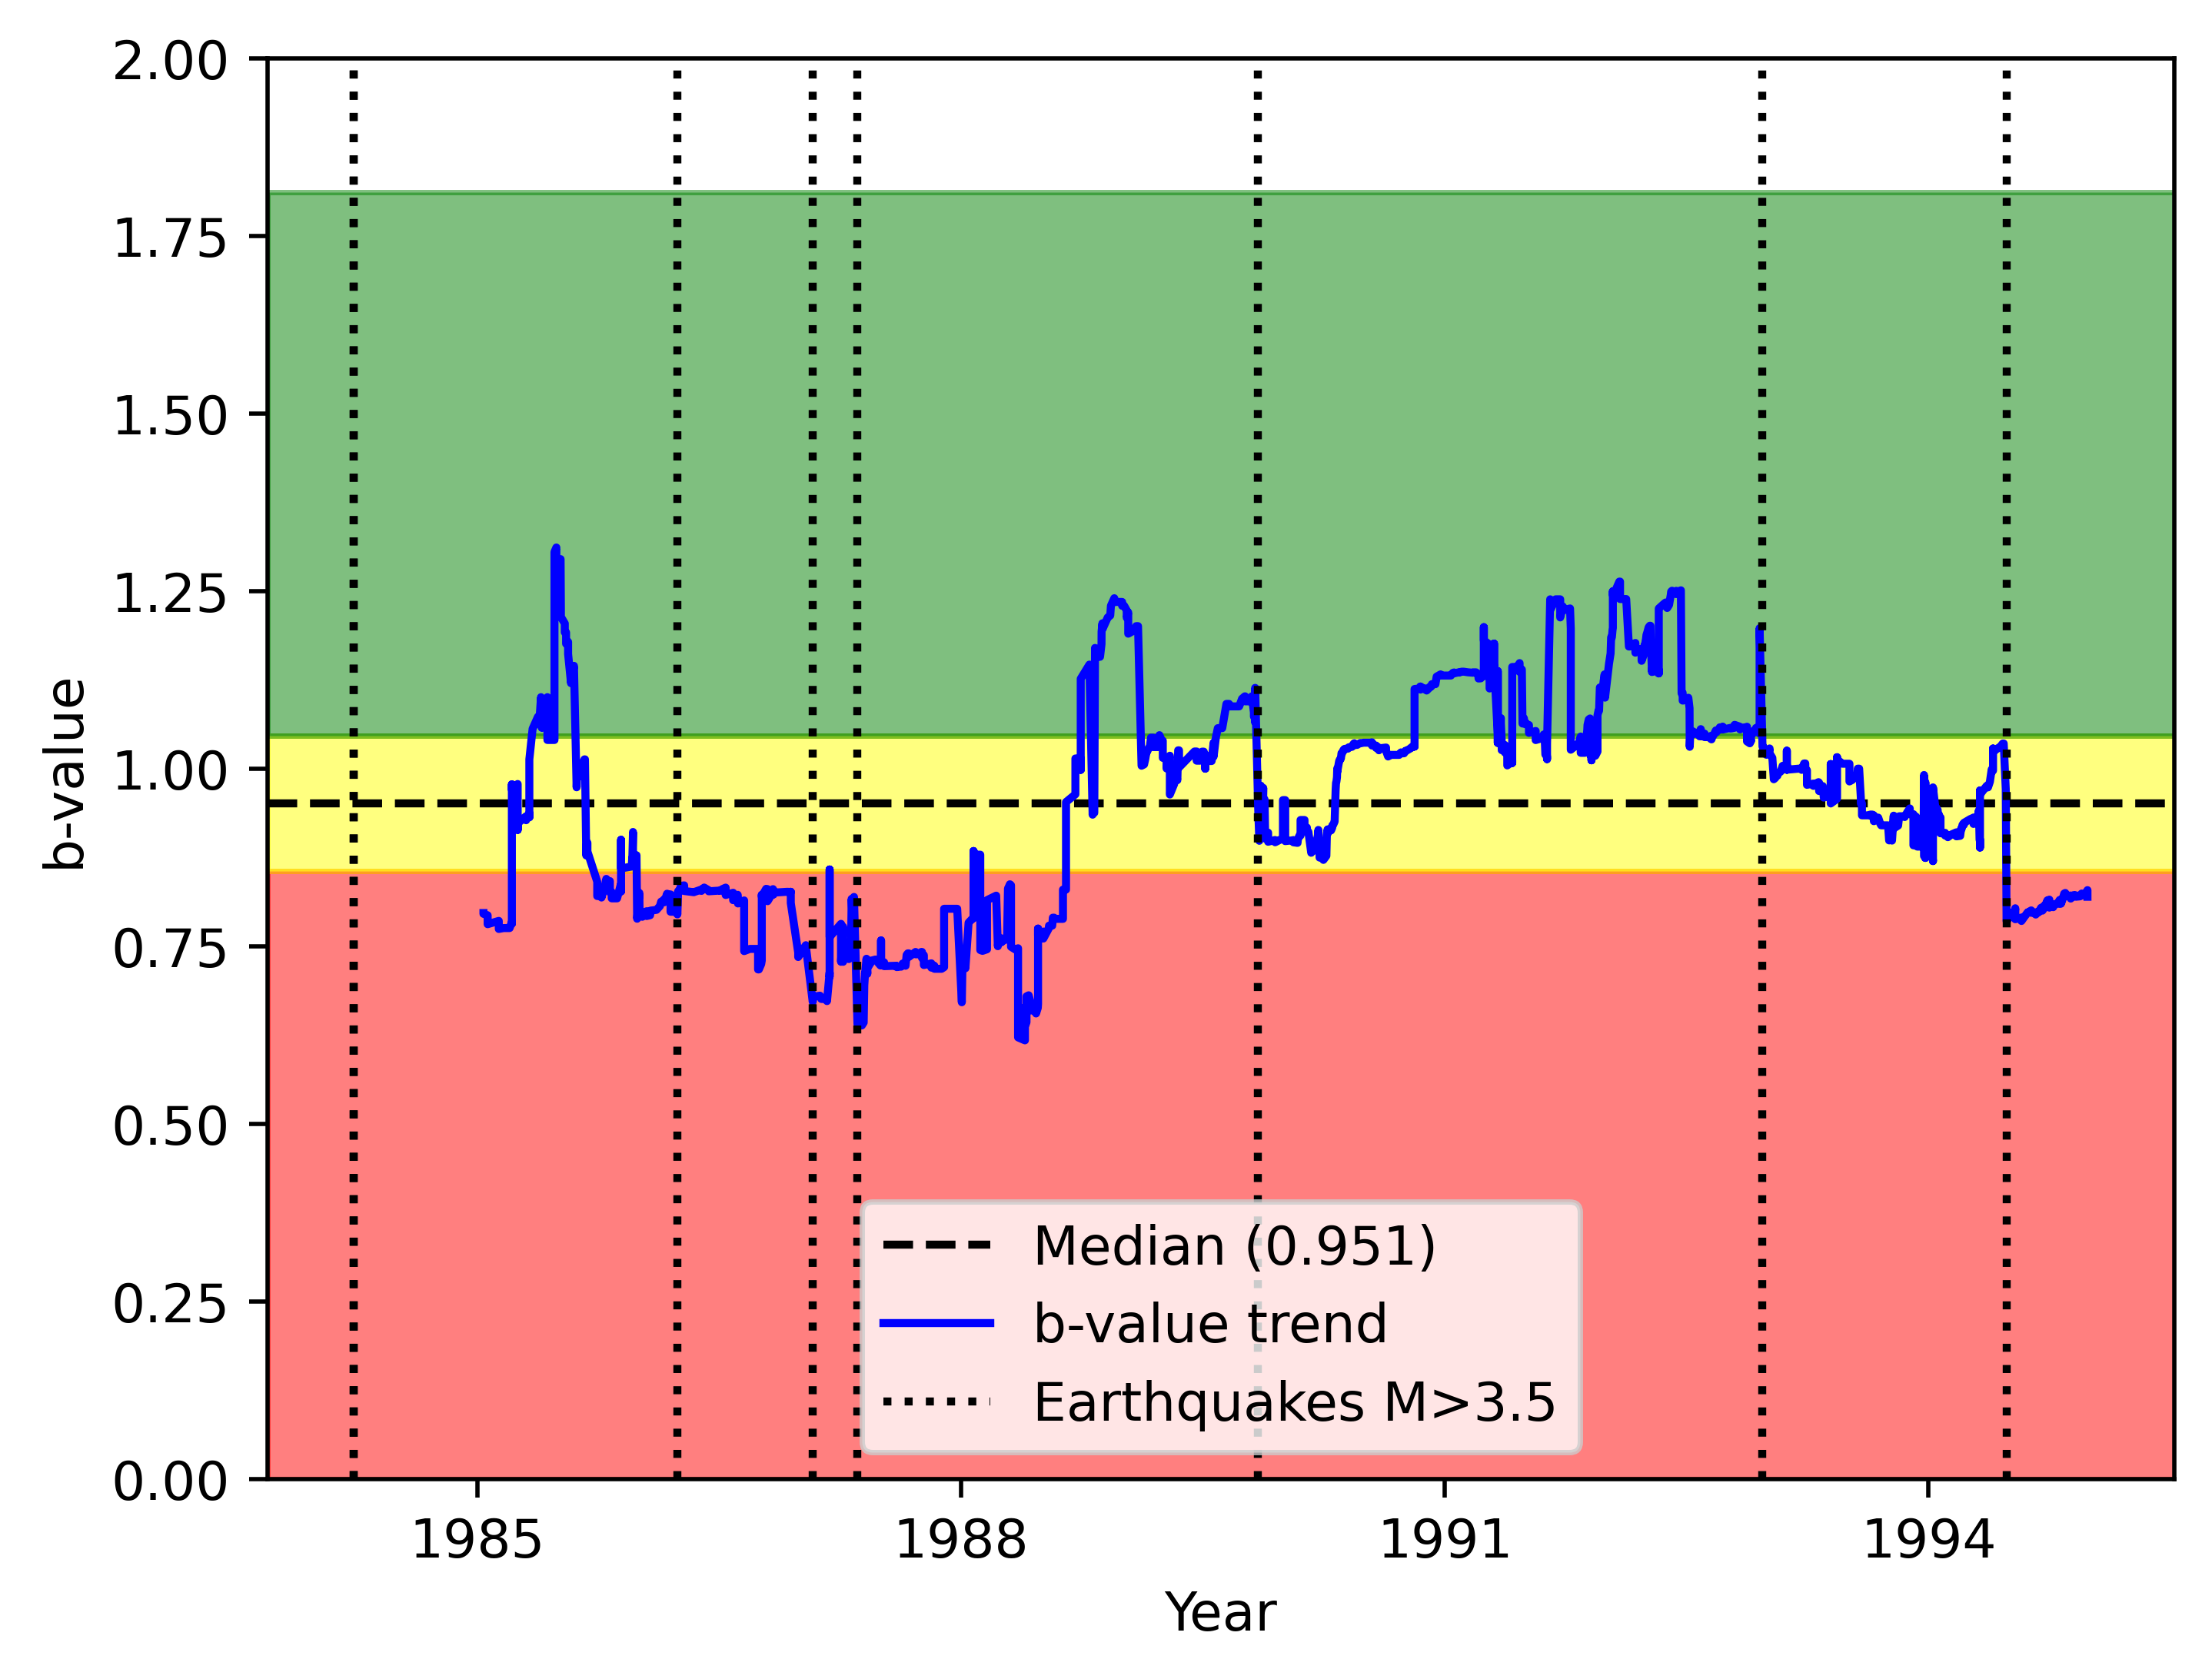

In [29]:
slideAtt = []
bDates = []

timeStart = np.min(time_year)
timeEnd = 1995#np.max(time_year) #or custom decimal year dates
print(timeEnd)
timeTotal = timeEnd - timeStart

areaParams = (dist_along_proj<70)&(dist_along_proj>0)&(dist_norm_proj<7)&(dist_norm_proj>-7)
timeParams = (time_year>timeStart)&(time_year<timeEnd)

#data = np.where(areaParams&timeParams)
data = np.where(timeParams&(mag<6))
print(data)
index = data[0]
print(index)

## make a map shwing the location of all the selected events

windowSize = 365 #in days
wsYears = windowSize / 365
inc = 1 #time increment per loop in days
incYears = inc / 365
steps = int(timeTotal/incYears)

print(steps)

for i in range(steps):
    ## make sure that the index list is unchanged
    w = 0
    wStart = timeStart + incYears * i
    wEnd = wStart + wsYears
    wParams = (time_year[index]>wStart)&(time_year[index]<wEnd)
    wIndices = np.where(wParams)[0]
    
    if len(wIndices) > 0:
        w = index[wIndices] # filter 'w' by 'wParams'
        bDates.append(time_year[w[-1]])  # append last event date in 'w'. Provided by ChatGPT
#     indexlist = []
#     for i, evid in enumerate(index):
#         if time_year[evid] > wStart:
#             if time_year[evid] < wEnd:
#                 indexlist.append(evid)
    # print(wStart,wEnd,w,indexlist)
    # print(wStart,wEnd,w,time_year[w])
    
    
    
    # bDates.append(wEnd)
    # bDates.append(time_year[w[len(w)-1]])
    # bDates.append(time_year[indexlist[len(indexlist)-1]])
    
    bW = calc_Mc_b(mag[w])[2]
    #bW = calc_Mc_b(mag[indexlist])[2]
    addbVal_slide(slideAtt,bW,bDates)
    #print(wStart,wEnd,len(w),bW,time_year[w[0]],time_year[w[len(w)-1]])
    #print(wStart,wEnd,len(indexlist),bW,time_year[indexlist[0]],time_year[indexlist[len(indexlist)-1]])
    
    #if i%250 == 0:
        #print(i,wEnd)
        
    if wEnd >= timeEnd:
        print(f"end of loop, steps: {i} out of {steps} needed; date of last eq: {wEnd}; last b: {bW}")
        xMin = np.min(bDates)
        xMax = np.max(bDates)
        print(f"x range: {xMin} to {xMax}; array lengths: {len(slideAtt),len(bDates)}")
        addbVal_slide(slideAtt,bW,bDates,xMin,xMax,1)
        break
        
bigMag = 3.5
bigEqs = np.where(areaParams&timeParams&(mag>bigMag))
bigDates = time_year[bigEqs]

for x in bigDates:
    if x == min(bigDates):
        plt.axvline(x, color='black', linestyle=':',label=f'Earthquakes M>{bigMag}')
    plt.axvline(x, color='black', linestyle=':')

#plt.axvline(x = 2018.004, color='red', linestyle='--', label='2018 Berkeley earthquake (M4.4)')
#plt.axvline(x = 2011.8014, color='purple', linestyle='--', label='2011 Berkeley earthquake swarm')
#plt.axvline(x = 2007.5493, color='yellow', linestyle='--', label='2007 Oakland Hills earthquake (M4.2)')
#plt.axvline(x = 1989.7932, color='gray', linestyle='--', label='1989 Loma Prieta earthquake (M7.0)')
plt.legend()